In [1]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses, Sequential
from tensorflow.keras.models import Model

In [2]:
# Loading the data
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


* A simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

* How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

In [4]:
# Splitting the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

* The data will be normalized to be in a range to be in between (0,1).

In [5]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val) 
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

* **min_val = tf.reduce_min(train_data):** This line calculates the minimum value present across all elements in the train_data tensor. tf.reduce_min efficiently finds the minimum element, considering all dimensions of the tensor.

* **max_val = tf.reduce_max(train_data):** Similarly, this line finds the maximum value in train_data.

* Will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

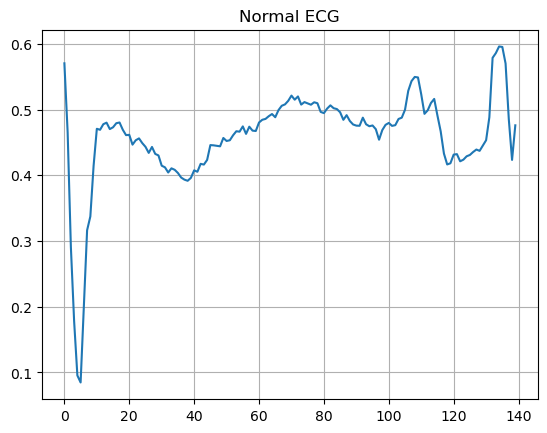

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("Normal ECG")
plt.show()

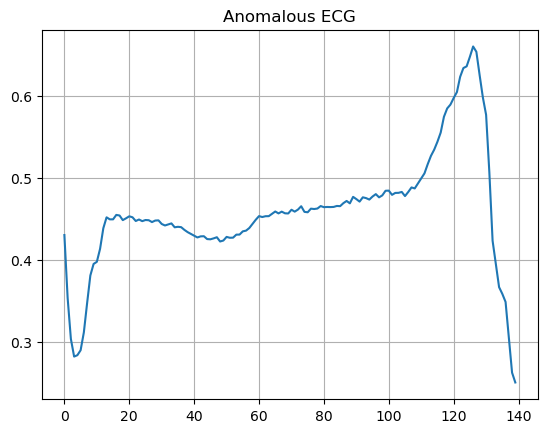

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("Anomalous ECG")
plt.show()

In [10]:
# Building the model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = Sequential([
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(8, activation='relu')
        ])

        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(140, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

In [15]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 135ms/step - loss: 0.0580 - accuracy: 0.0195 - val_loss: 0.0536 - val_accuracy: 0.0210
Epoch 2/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0568 - accuracy: 0.0170 - val_loss: 0.0525 - val_accuracy: 0.0040
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0551 - accuracy: 0.0085 - val_loss: 0.0511 - val_accuracy: 0.0040
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0523 - accuracy: 0.0085 - val_loss: 0.0501 - val_accuracy: 0.0040
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0488 - accuracy: 0.0085 - val_loss: 0.0475 - val_accuracy: 0.0040
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0447 - accuracy: 0.0517 - val_loss: 0.0461 - val_accuracy: 0.0410
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0410 - accuracy: 0.0835 - val_loss: 0.0440 - val_accuracy: 0.0410
Epoch 8/20
5/5 [==========

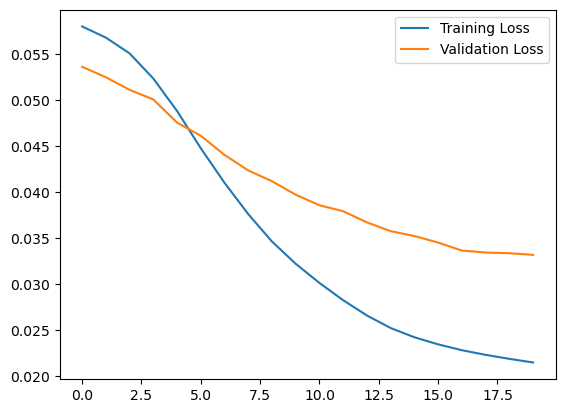

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

* First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

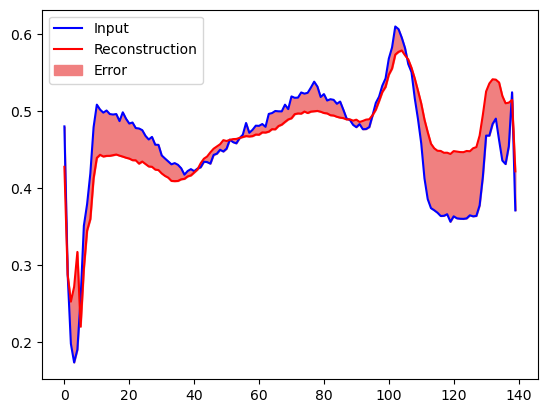

In [18]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

* Create a similar plot, this time for an anomalous test example.                

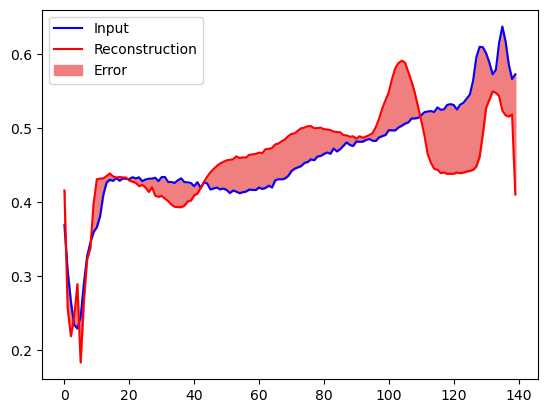

In [20]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

* Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 

* Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 4ms/step


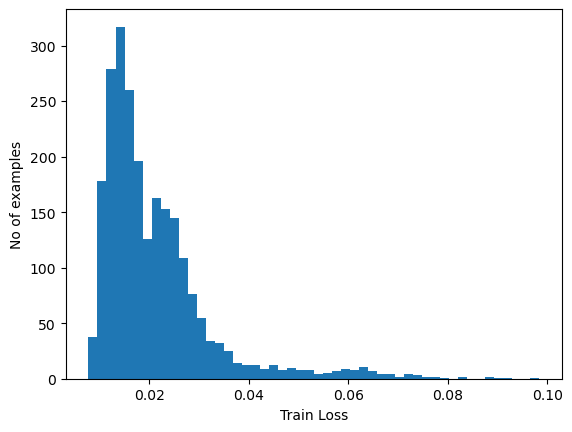

In [22]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Train Loss')
plt.ylabel('No of examples')
plt.show()

* Choose a threshold value that is one standard deviation above the mean.

In [23]:
threshold = np.mean(train_loss) + np.std(train_loss)
threshold

0.032902606

14/14 [==============================] - 0s 5ms/step


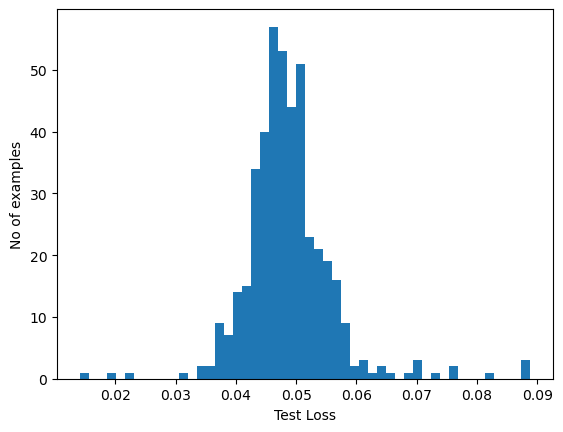

In [24]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = losses.mae(reconstructions, anomalous_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Test Loss')
plt.ylabel('No of examples')
plt.show()

* An ECG is classified an anomaly if the reconstruction error is greater than the threshold

In [25]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

**return tf.math.less(loss, threshold):** 
* It takes two tensors (tensors are multidimensional arrays in TensorFlow) as input:
  
    **loss:** The tensor containing the calculated MAE loss for each data point.

    **threshold:** A scalar value (a single number) representing the threshold for the loss.
  
* It performs an **element-wise comparison** between the corresponding elements in the loss tensor and the threshold.

* It returns a new tensor of the same shape as loss, where each element is a Boolean value (True or False).

        If the corresponding element in loss is less than the threshold, the element in the output tensor will be True.
        
        If the corresponding element in loss is greater than or equal to the threshold, the element in the output tensor will be False.

In [26]:
def print_stats(predictions, labels):
    print('Accuracy = {}'.format(accuracy_score(labels, predictions)))
    print('Precision = {}'.format(precision_score(labels, predictions)))
    print('Recall = {}'.format(recall_score(labels, predictions)))

In [27]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
